In [1]:
#Mains
import numpy as np
import pandas as pd
import re
import string
#Models
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
#Sklearn Helpers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import chi2
#For plots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

C:\Users\turgu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
#dataset=pd.read_csv('offenseval-tr-training-v1.tsv', sep='\t')
dataset = pd.read_csv('data/troff-v1.0.tsv', sep='\t')
dataset.head()

,id,timestamp,text,label
0,973568937593065472,1520952977415,"@USER06095 Hırsız demişken Tuncay sizin şu 1.200 bin TL'lik faturayı naptınız malum MİLLETE kitlesiniz ya, sizden âlâ HIRSIZ varmı bu ülkede banka soyarken kâr MASKESİ ülke soyarken Atatürk'ün MASKESİ çoooooookk yüzsünüz CHP OLARAK...",grp
1,973568937723035648,1520952977446,Ne bileyim sen hastayım deyince bende veteriner okumaya karar verdim,ind
2,973568937911873536,1520952977491,Akşam eve gittiğimizde yorgunluğuma iyi gelecek bi bayan olmalı evde,grp
3,973568939925090304,1520952977971,Kook’un sesini 18381 kez dinledikten sonra eğer devam edersem ağlamaktan gözüm şişer annem ağzıma sıçar hangsang dinleyip enerji toplıyım,prof
4,973568940667539457,1520952978148,@USER05270 @USER04816 o macta adam 6 7 tane net sut cikartti aksini soleyen ya maldir yada futboldan anlamiyodur buna benzer bir pozisyon da wesley uzaktan attigi golun birinde de ayni pozisyon vardi ozaman bunu size en iyi volkan aciklar kudurun fesat ibneler.,grp


In [3]:
dataset['text'] = dataset['text'].str.lower()
dataset['text'].head()

0    @user06095 hırsız demişken tuncay sizin şu 1.200 bin tl'lik faturayı naptınız malum mi̇llete kitlesiniz ya, sizden âlâ hirsiz varmı bu ülkede banka soyarken kâr maskesi̇ ülke soyarken atatürk'ün maskesi̇ çoooooookk yüzsünüz chp olarak...                        
1    ne bileyim sen hastayım deyince bende veteriner okumaya karar verdim                                                                                                                                                                                                 
2    akşam eve gittiğimizde yorgunluğuma iyi gelecek bi bayan olmalı evde                                                                                                                                                                                                 
3    kook’un sesini 18381 kez dinledikten sonra eğer devam edersem ağlamaktan gözüm şişer annem ağzıma sıçar hangsang dinleyip enerji toplıyım                                                         

In [4]:
stop_words=pd.read_csv('https://raw.githubusercontent.com/InJuxSanct/turkish-stopwords/master/src/lib/stopwords/raw-stopwords.txt', sep=' ', header=None)
stop_words.columns=['words_list']
STOPWORDS = set(stop_words['words_list'])
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

0    @user06095 hırsız demişken tuncay 1.200 tl'lik faturayı naptınız malum mi̇llete kitlesiniz ya, âlâ hirsiz varmı ülkede banka soyarken kâr maskesi̇ ülke soyarken atatürk'ün maskesi̇ çoooooookk yüzsünüz chp olarak...               
1    bileyim hastayım deyince bende veteriner okumaya karar verdim                                                                                                                                                                        
2    akşam eve gittiğimizde yorgunluğuma gelecek bi bayan olmalı evde                                                                                                                                                                     
3    kook’un sesini 18381 dinledikten devam edersem ağlamaktan gözüm şişer annem ağzıma sıçar hangsang dinleyip enerji toplıyım                                                                                                           
4    @user05270 @user04816 macta adam 6 7 tane net sut cikar

In [12]:
brands=pd.read_csv('https://raw.githubusercontent.com/pytmar/Jupyter-Notebooks/master/turkish_brands%20-%20Sayfa1.csv', header=None)
print(brands)
brands.columns=['0']
BRANDS = set(brands['0'])
def cleaning_brands(text):
    return " ".join([brand for brand in str(text).split() if brand not in BRANDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_brands(text))
dataset['text'].head()

                   0
0    101 Okey Plus  
1    111parfum.com  
2    112 Acil Servis
3    1tarz          
4    212 AVM        
..       ...        
544  ets tur        
545  mate 20        
546  bein connect   
547  Ziraat Bankasi 
548  blutv          

[549 rows x 1 columns]


0    @user06095 hırsız demişken tuncay 1.200 tl'lik faturayı naptınız malum mi̇llete kitlesiniz ya, âlâ hirsiz varmı ülkede banka soyarken kâr maskesi̇ ülke soyarken atatürk'ün maskesi̇ çoooooookk yüzsünüz chp olarak...               
1    bileyim hastayım deyince bende veteriner okumaya karar verdim                                                                                                                                                                        
2    akşam eve gittiğimizde yorgunluğuma gelecek bi bayan olmalı evde                                                                                                                                                                     
3    kook’un sesini 18381 dinledikten devam edersem ağlamaktan gözüm şişer annem ağzıma sıçar hangsang dinleyip enerji toplıyım                                                                                                           
4    @user05270 @user04816 macta adam 6 7 tane net sut cikar

In [13]:
def remove_usernames_links(tweet):
    tweet = re.sub("@[A-Za-z0-9]+",'',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    return tweet
dataset['text'] = dataset['text'].apply(lambda x: remove_usernames_links(x))
dataset['text'].head()

0     hırsız demişken tuncay 1.200 tl'lik faturayı naptınız malum mi̇llete kitlesiniz ya, âlâ hirsiz varmı ülkede banka soyarken kâr maskesi̇ ülke soyarken atatürk'ün maskesi̇ çoooooookk yüzsünüz chp olarak...     
1    bileyim hastayım deyince bende veteriner okumaya karar verdim                                                                                                                                                    
2    akşam eve gittiğimizde yorgunluğuma gelecek bi bayan olmalı evde                                                                                                                                                 
3    kook’un sesini 18381 dinledikten devam edersem ağlamaktan gözüm şişer annem ağzıma sıçar hangsang dinleyip enerji toplıyım                                                                                       
4      macta adam 6 7 tane net sut cikartti aksini soleyen maldir yada futboldan anlamiyodur benzer pozisyon wesley uzaktan attigi golun bir

In [14]:
import string
table = str.maketrans('', '', string.punctuation)
def cleaning_punctuations(s):
        res = [w.translate(table) for w in s.split()]
        return " ".join(res)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].head()

0    hırsız demişken tuncay 1200 tllik faturayı naptınız malum mi̇llete kitlesiniz ya âlâ hirsiz varmı ülkede banka soyarken kâr maskesi̇ ülke soyarken atatürkün maskesi̇ çoooooookk yüzsünüz chp olarak          
1    bileyim hastayım deyince bende veteriner okumaya karar verdim                                                                                                                                                 
2    akşam eve gittiğimizde yorgunluğuma gelecek bi bayan olmalı evde                                                                                                                                              
3    kook’un sesini 18381 dinledikten devam edersem ağlamaktan gözüm şişer annem ağzıma sıçar hangsang dinleyip enerji toplıyım                                                                                    
4    macta adam 6 7 tane net sut cikartti aksini soleyen maldir yada futboldan anlamiyodur benzer pozisyon wesley uzaktan attigi golun birinde ayni pozi

In [15]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].head()

0    hırsız demişken tuncay1200 tllik faturayı naptınız malum mi̇llete kitlesiniz ya âlâ hirsiz varmı ülkede banka soyarken kâr maskesi̇ ülke soyarken atatürkün maskesi̇ çoooooookk yüzsünüz chp olarak           
1    bileyim hastayım deyince bende veteriner okumaya karar verdim                                                                                                                                                 
2    akşam eve gittiğimizde yorgunluğuma gelecek bi bayan olmalı evde                                                                                                                                              
3    kook’un sesini1831 dinledikten devam edersem ağlamaktan gözüm şişer annem ağzıma sıçar hangsang dinleyip enerji toplıyım                                                                                      
4    macta adam 6 7 tane net sut cikartti aksini soleyen maldir yada futboldan anlamiyodur benzer pozisyon wesley uzaktan attigi golun birinde ayni pozi

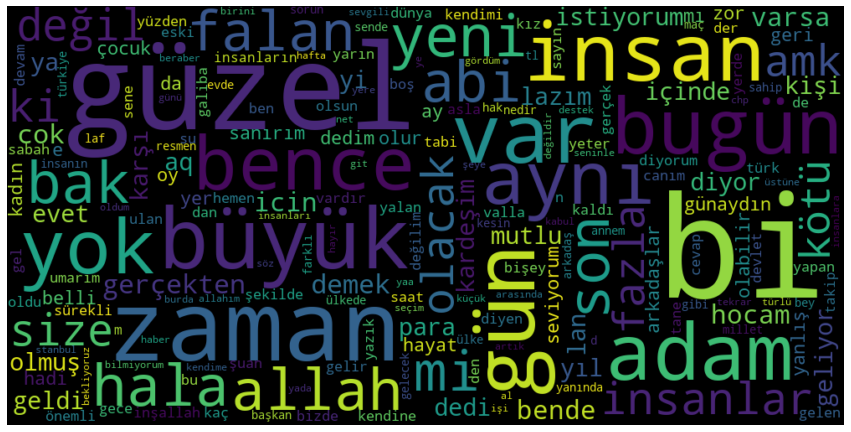

In [16]:
wordcloud = WordCloud(width=1000, height=500).generate("+".join(dataset['text']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
X = dataset['text']
y = dataset['label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
trial = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', SGDClassifier()),])
parameters = {
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
 'tfidf__use_idf': (True, False),
 'tfidf__norm': ('l1', 'l2'),
 'clf__max_iter': (20,),
 'clf__alpha': (0.00001, 0.000001),
 'clf__penalty': ('l2', 'elasticnet'),
 'clf__max_iter': (10, 50, 80),
}
grid_search = GridSearchCV(trial, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best score: 0.848
Best parameters set:
{'memory': None, 'steps': [('vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(alpha=1e-05, max_iter=80, penalty='elasticnet'))], 'verbose': False, 'vect': CountVectorizer(max_df=0.75, ngram_range=(1, 2)), 'tfidf': TfidfTransformer(), 'clf': SGDClassifier(alpha=1e-05, max_iter=80, penalty='elasticnet'), 'vect__analyzer': 'word', 'vect__binary': False, 'vect__decode_error': 'strict', 'vect__dtype': <class 'numpy.int64'>, 'vect__encoding': 'utf-8', 'vect__input': 'content', 'vect__lowercase': True, 'vect__max_df': 0.75, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__preprocessor': None, 'vect__stop_words': None, 'vect__strip_accents': None, 'vect__token_pattern': '(?u)\\b\\w\\w+\\b', 'vect__tokenizer': None, 'vect__vocabulary': None, 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'tfidf__s

In [32]:
best_parameters['steps']

[('vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))),
 ('tfidf', TfidfTransformer()),
 ('clf', SGDClassifier(alpha=1e-05, max_iter=80, penalty='elasticnet'))]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
trial = Pipeline([(
  'vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))),
 ('tfidf', TfidfTransformer()),
 ('clf', SGDClassifier(loss='modified_huber',alpha=1e-05, max_iter=80, penalty='elasticnet')),])
trial.fit(X_train, y_train)
print("Accuracy: " + str(trial.score(X_test, y_test)))

Accuracy: 0.8325586668178211


In [19]:
predictions = trial.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(f"{accuracy_score(y_test, predictions)}")
print("****")
print(classification_report(y_test, predictions))
print("****")

[[  55   53  285    1   19]
 [  36  154  572    0   52]
 [  41   98 6980    3   26]
 [   2   12   68    0   10]
 [   3   27  169    0  155]]
0.8325586668178211
****
              precision    recall  f1-score   support

         grp       0.40      0.13      0.20       413
         ind       0.45      0.19      0.27       814
         non       0.86      0.98      0.92      7148
         oth       0.00      0.00      0.00        92
        prof       0.59      0.44      0.50       354

    accuracy                           0.83      8821
   macro avg       0.46      0.35      0.38      8821
weighted avg       0.78      0.83      0.80      8821

****


In [20]:
test = ['berna takımla iyi anlaşıyor diye linç yiyor zamanında da takımla iyi anlaşmıyor diye linç yiyodu kız linç yemek için doğmuş amk allah akıl fikir versin size',
 'Yarrak gibi hayat amk',
 'sırf camia istedi biz de oynattık demek için yapılmış kadro. İleri uçta kenan ve güven ile gol arayacağız. Şaka gibi amk.',
 'quoradan çıkamıyorum amk',
 '@buddwifey Bu videoyu her izlediğimde uçuyorum amk HAHAHAHAHAAHHAAHAHSKLDFĞ',
 '@supperbey @uyanhadi_ Aldığın asgari ücret 4k ama amk salağı seni',
 '@BiraVeVotka Ne yapsak kume dusuyoruz amk😂 yok mu camianin evladi bir sey, bizi bu durumdan kurtarsin😂',
 'on gündür maske almayı unutuyorum kullandığım maske rambo okanın maskesi gibi oldu amk',
 'Biraz daha koysalar kendi tavuk pilavcımı açarım amk https://t.co/DvRA0g5WYm',
 '70 yaşındaki bir bunağa Federasyon koltuğunu emanet edersen olacağı bu olur amk https://t.co/X8qTQFdPbR']
trial.predict(test)

array(['ind', 'prof', 'prof', 'prof', 'prof', 'prof', 'prof', 'prof',
       'prof', 'prof'], dtype='<U4')

In [40]:
import joblib

joblib.dump(trial, 'model2.joblib')

['model2.joblib']